**Decision Tree**

In [32]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,ConfusionMatrixDisplay,roc_auc_score,roc_curve,auc,precision_recall_curve,mean_absolute_error,log_loss,jaccard_score,matthews_corrcoef,cohen_kappa_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import  GridSearchCV

In [34]:
#loading the transformed Data Set
solar_data = pd.read_csv(r"C:\Users\bathl\OneDrive\Documents\SJSU\Machine_Learning\Project\solar_data_transformed18.csv")

In [36]:
# Exclude the target and ID column from the PCA analysis
X = solar_data.drop(['InstallType','ID'], axis=1)

# Prepare data for classification
X_train, X_test, y_train, y_test = train_test_split(X, solar_data['InstallType'], test_size=0.3, random_state=42)

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)

# Evaluate Decision Tree
dt_accuracy = accuracy_score(y_test, y_pred_dt)

#target column values' mapping
class_mapping = {
    0: "Ground",
    1: "Parking",
    2: "Rooftop"
}

target_names = [class_mapping[label] for label in sorted(class_mapping.keys())]

dt_report = classification_report(y_test, y_pred_dt,target_names=target_names)
print("Decision Tree Accuracy:", dt_accuracy)
print("Decision Tree Classification Report:\n", dt_report)


Decision Tree Accuracy: 0.9104938271604939
Decision Tree Classification Report:
               precision    recall  f1-score   support

      Ground       0.93      0.93      0.93       647
     Parking       0.92      0.88      0.90       416
     Rooftop       0.89      0.91      0.90       557

    accuracy                           0.91      1620
   macro avg       0.91      0.91      0.91      1620
weighted avg       0.91      0.91      0.91      1620



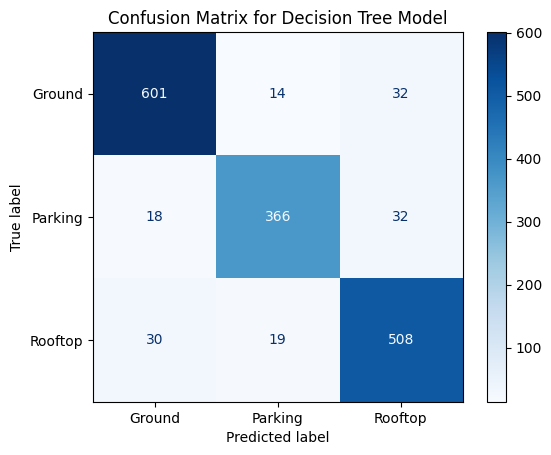

In [37]:
#Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot(cmap='Blues')
# Add labels to the plot
class_names = ['Ground', 'Parking', 'Rooftop']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Decision Tree Model')
plt.show()

In [39]:
# Decision Tree Tuning
dt_param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'] 
}

dt_grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [40]:
# Best parameters and performance
best_dt = dt_grid_search.best_estimator_
y_pred_dt_tuned = best_dt.predict(X_test)
dt_tuned_accuracy = accuracy_score(y_test, y_pred_dt_tuned)

#target column values' mapping
class_mapping = {
    0: "Ground",
    1: "Parking",
    2: "Rooftop"
}

target_names = [class_mapping[label] for label in sorted(class_mapping.keys())]

dt_tuned_report = classification_report(y_test, y_pred_dt_tuned,target_names=target_names)

print("Tuned Decision Tree Accuracy:", dt_tuned_accuracy)
print("Tuned Decision Tree Classification Report:\n", dt_tuned_report)

Tuned Decision Tree Accuracy: 0.904320987654321
Tuned Decision Tree Classification Report:
               precision    recall  f1-score   support

      Ground       0.92      0.94      0.93       647
     Parking       0.91      0.89      0.90       416
     Rooftop       0.89      0.88      0.88       557

    accuracy                           0.90      1620
   macro avg       0.90      0.90      0.90      1620
weighted avg       0.90      0.90      0.90      1620



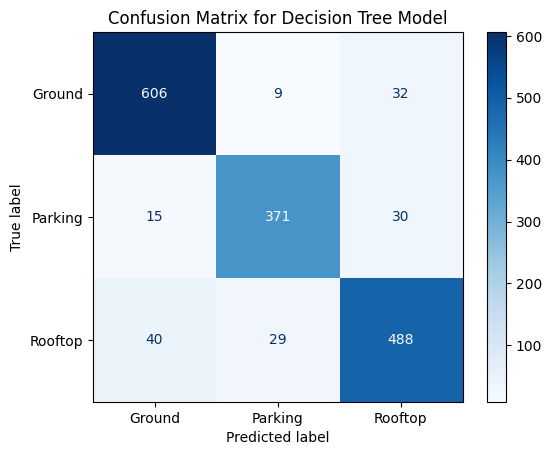

In [41]:
conf_matrix = confusion_matrix(y_test, y_pred_dt_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')

# Add labels to the plot
class_names = ['Ground', 'Parking', 'Rooftop']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Decision Tree Model')
plt.show()

**DecisionTree Insights**

The performance metrics are a bit different for the Decision Tree and its tuned variant; the original Decision Tree is slightly more accurate than the tuned model.

1. The accuracy differs from 91.04% to 90.61% indicating Decision tree before fine tuning is slightlty better.
2. Precision, recall, and F1-scores are consistent around 0.91 across both models, indicating that both models provide comparable reliability for classification tasks.
3. However, its performance lags behind the Random Forest, suggesting that ensemble methods remain more effective for this dataset.

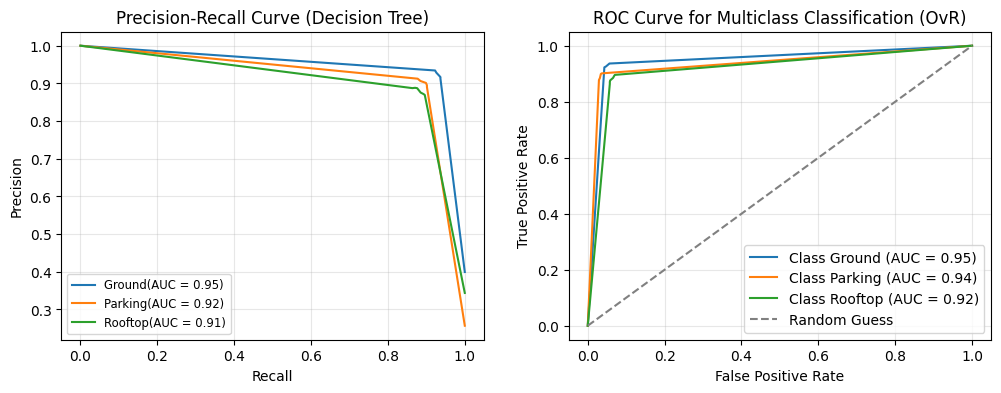

In [46]:
#Define a mapping for class names
class_mapping = {
    0: "Ground",
    1: "Parking",
    2: "Rooftop"
}

# Ensure classes are correctly labeled and binarized
n_classes = len(best_dt.classes_)  # Number of classes
y_test_bin = label_binarize(y_test, classes=best_dt.classes_)  # Binarize y_test

# Ensure probabilities are available for all classes
y_prob = best_dt.predict_proba(X_test)  # Predicted probabilities

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 

# Plot Precision-Recall Curves
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    pr_auc = auc(recall, precision)
    class_name = class_mapping[best_dt.classes_[i]] 
    axes[0].plot(recall, precision, label=f"{class_name}(AUC = {pr_auc:.2f})")

axes[0].set_title("Precision-Recall Curve (Decision Tree)", fontsize=12)
axes[0].set_xlabel("Recall", fontsize=10)
axes[0].set_ylabel("Precision", fontsize=10)
axes[0].legend(loc="lower left", fontsize='small')
axes[0].grid(alpha=0.3)


# Plotting the ROC Curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])  # Compute FPR and TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC
    class_name = class_mapping[best_dt.classes_[i]]
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")

# Customize the plot
plt.title("ROC Curve for Multiclass Classification (OvR)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Precision-Recall Curve:

1. All three classes experience a decline in precision as recall approaches 1.0, indicating a higher proportion of false positives at these thresholds.
2. The Rooftop class shows the sharpest drop, suggesting the model struggles more with distinguishing this class compared to the others.
3. Lower AUC values for Parking and Rooftop suggest these classes might be harder to predict due to class overlap or fewer training examples.
4. Decision Trees are prone to overfitting, which might explain the less smooth curves and slightly lower AUC values compared to ensemble models like Random Forests.

ROC-AUC curve:

1. The AUC values are close across all three classes, indicating relatively balanced discrimination capability.
2. The slightly lower AUC for Rooftop suggests that this class is more challenging to differentiate.

In [49]:
#Use roc_auc_score with 'ovr' or 'ovo' for multiclass
print("ROC-AUC Score (OVR):", roc_auc_score(y_test, y_prob, multi_class='ovr'))
print("ROC-AUC Score (OVO):", roc_auc_score(y_test, y_prob, multi_class='ovo'))

ROC-AUC Score (OVR): 0.9328632317865843
ROC-AUC Score (OVO): 0.93257436851026


In [51]:
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred_dt_tuned))

Matthews Correlation Coefficient: 0.8541057239458005


In [53]:
print("Jaccard Score (Macro):", jaccard_score(y_test, y_pred_dt_tuned, average='macro'))

Jaccard Score (Macro): 0.8229322720045998


In [55]:
#Passing the true labels explicitly
unique_classes = best_dt.classes_
print("Log Loss:", log_loss(y_test, y_prob, labels=unique_classes))

Log Loss: 3.130254726528037


In [57]:
mae = mean_absolute_error(y_test, y_pred_dt_tuned)
print(f"Squared Loss (Mean Squared Error): {mae:.4f}")

Squared Loss (Mean Squared Error): 0.1401


In [59]:
kappa_score = cohen_kappa_score(y_test, y_pred_dt_tuned)
print("Cohen's Kappa Score:", kappa_score)

Cohen's Kappa Score: 0.8540319106821784
